In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../environments/'); import gw
sys.path.insert(0,'../environments/'); import gridworld_plotting as gp
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec


import experiment as expt

#####
import torch

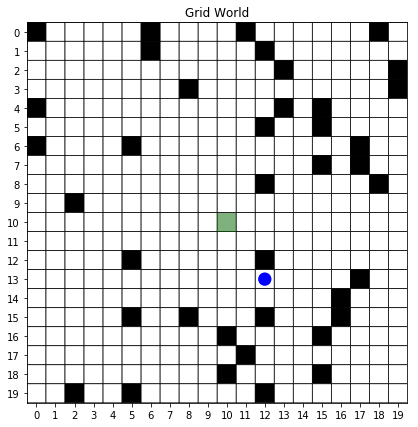

In [2]:
rows, columns = 20, 20 
env = gw.GridWorld(rows=rows,cols=columns, 
                   rewards={(int(rows/2),int(columns/2)):1},
                   step_penalization=-0.01,
                   rho=0.1)
fig = gw.plotWorld(env,current_state=True,scale=0.35)

In [3]:
agent_params = { 
    'load_model':  False,
    'load_dir':     f'../data/outputs/gridworld/openfield{rows}{columns}.pt',
    'freeze_w':    False,
    
    'input_dims':  env.observation.shape,
    'action_dims': len(env.action_list),
    'hidden_types':['conv','pool','conv','pool','linear','linear'],
    'hidden_dims': [None, None, None, None, 500, 200],
                
    'rfsize':      5,
    'stride':      1,
    'padding':     1,
    'dilation':    1,
    
    'gamma':       0.98,
    'eta':         5e-4,
    
    'use_EC':      True,
    'EC':          {},
    'cachelim':    300,
    'mem_temp':    0.3    
}

In [4]:
def get_snapshot(env, agent):
    # get sample observations from all useable spaces in environment
    samples, states = env.get_sample_obs()
    
    # forward pass through network
    pols, vals = agent(torch.Tensor(samples))
    
    # initialize empty data frames
    pol_grid = np.zeros(env.shape, dtype=[('N', 'f8'), ('E', 'f8'), ('W', 'f8'), ('S', 'f8'), ('stay', 'f8'), ('poke', 'f8')])
    val_grid = np.empty(env.shape)
    
    # populate with data from network
    for s, p, v in zip(states, pols, vals):
        pol_grid[s] = p.data[0].numpy()
        val_grid[s] = v.item()
    
    return pol_grid, val_grid

def make_agent(agent_params, freeze=False):
    if agent_params['load_model']:
        # load previously saved model
        MF = torch.load(agent_params['load_dir']) 
    else:
        MF = ac.ActorCritic(agent_params)

    if freeze:
        freeze = []
        unfreeze = []
        for i, nums in MF.named_parameters():
            if i[0:6] == 'output':
                unfreeze.append(nums)
            else:
                freeze.append(nums)
        MF.optimizer = optim.Adam([{'params': freeze, 'lr': 0.0}, {'params': unfreeze, 'lr': agent_params['eta']}], lr=0.0)
    else:
        MF.optimizer = optim.Adam(MF.parameters(), lr= agent_params['eta'])
    return MF

In [5]:
## Parameters
NUM_TRIALS = 2
NUM_EVENTS = 3
agent = ac.ActorCritic(agent_params)

In [6]:
def experiment(NUM_TRIALS, NUM_EVENTS, environment, agent,
               **kwargs):
        
    for trial in range(NUM_TRIALS):
        for event in range(NUM_EVENTS): 
            #get state observation
            observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))
            
            #pass observation through network
            policy_, value_ = agent(observation)
            
            #select action from policy
            choice = agent.select_action(policy_, value_)
            action = env.action_list[choice][0]
            
            #take a step in the environment
            s_1d, reward, __ = env.move(action)
            print(s_1d, reward)
            
            
            
            

In [7]:
experiment(NUM_TRIALS, NUM_EVENTS, env, agent)

273 -0.01


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
reload(gp)
gp.plot_polmap(env, pol_grid, threshold =0)
gp.plot_valmap(env, val_grid)

In [ ]:
print(env.state, oneD2twoD(env.state, env.shape))
fig = plotWorld(env,current_state=False)

num_steps = 10
moves = True
if moves:
    for _ in range(num_steps):
        if _ == 0:
            action_choice = ""
        start_at = oneD2twoD(env.state, env.shape)
        # draw state
        agent_y, agent_x = oneD2twoD(env.state, env.shape)
        agent_dot = plt.Circle((agent_x + .5, agent_y + .5), 0.35, fc='b')
        fig.gca().add_artist(agent_dot)

        # select action
        action_choice = random_policy(env)
        env.move(action_choice)

        print(f"{start_at}:{action_choice} --> {oneD2twoD(env.state, env.shape)}")
        text = plt.gcf().text(0.1, 0.9, f'Agent Chooses: {action_choice}', fontsize=14)

        plt.pause(1)
        plt.draw()
        dx1, dy1, head_w, head_l = make_arrows(env.action_dict[action_choice])
        if action_choice == 'P':
            arrow = plt.text(agent_x+0.49, agent_y+0.6, "*", {'color': 'white', 'fontsize': 24, 'ha': 'center', 'va': 'center'})
        else:
            arrow = plt.arrow(agent_x+0.5, agent_y+0.5, dx1, dy1, head_width=0.3, head_length=0.2, color="cyan")


        plt.pause(.5)
        plt.draw()

        if _ < num_steps-1:
            agent_dot.remove()
            arrow.remove()
            text.remove()
plt.show()